In [165]:
import openxdf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from pathlib import Path
import csv
import pickle
import seaborn as sbn

In [122]:
path = Path('/Users/danielyaeger/Documents/sleep_data')
path_to_csv = path.joinpath('Dennis_Scored_XDF.xlsx')
path_to_data = path.joinpath('Dennis_Scored_XDF')

# Create list of datafiles
f_list = [f.parent.joinpath(f.stem) for f in path_to_data.iterdir() if f.suffix == '.xdf']

# Load Dennis scored CSV
dennis_list = pd.ExcelFile('/Users/danielyaeger/Documents/sleep_data/Dennis_Scored_XDF.xlsx')
dennis_list = dennis_list.parse('dennis_rbd_catalog')



In [123]:
def select_rem_epochs(xdf, scorer="Dennis"):
    staging = xdf.dataframe(epochs=True, events=False)
    staging = staging[staging["Scorer"] == scorer].reset_index(drop=True)
    return staging[staging["Stage"] == "R"].reset_index(drop=True)
    
def select_rswa_events(xdf, scorer="Dennis"):
    staging = xdf.dataframe(epochs=False, events=True)
    staging = staging[staging["Scorer"] == scorer].reset_index(drop=True)
    staging = staging[staging["CEName"].isnull() | staging["CEName"].isin(["RSWA_T", "RSWA_P"])]
    staging = staging[staging["CEName"].isin(["RSWA_T", "RSWA_P"])]
    return staging

In [169]:
def make_rswa_dict():
    n_tot = len(f_list)
    pat_dict = {}
    rem_dict = {}
    rswa_dict = {}
    excl_records = []
    columns_summary = ["ID", "study_time_seconds", "n_epoch_tot", "n_epoch_rem", "n_epoch_rswa", 
               "n_rswa_p", "n_rswa_t", "mean_duration_p", "mean_duration_t"]
    columns_rem_periods = ["ID","REM_Period","REM_epoch_start","REM_epoch_end"]
    columns_rswa_events = ["ID","EpochNumber","Start","End","CEName"]

    # exclusion criteria
    min_hours = 4
    

    tstart = time.time()
    with path.joinpath("summary_by_id.csv").open("w") as sum_out:
        with path.joinpath("REM_periods_by_id.csv").open("w") as rem_out:
            with path.joinpath("RSWA_events_by_id.csv").open("w") as rswa_out:
                # Initialize csv writers
                writer_sum = csv.writer(sum_out)
                writer_rem = csv.writer(rem_out)
                writer_rswa = csv.writer(rswa_out)
                
                # Write columns
                writer_sum.writerow(columns_summary)
                writer_rem.writerow(columns_rem_periods)
                writer_rswa.writerow(columns_rswa_events)
                
                for i, f in enumerate(f_list):
                    f = str(f)
                    print(f"processing {i + 1:3d} / {n_tot} files")
                    # just incase not every xdf file has a corresponding nkamp file and vice versa
                    try:
                        # Open file
                        xdf = openxdf.OpenXDF(f + '.xdf')
                        patient_id = f.split("/")[-1]
                        xdf_df = xdf.dataframe()
                        rem_epochs = select_rem_epochs(xdf)
                        n_epoch_rem = len(rem_epochs)

                        # check if subject did not complete the study (at least 6 hours)
                        n_epoch_tot = xdf_df.loc[:, "EpochNumber"].max()
                        study_time_seconds = n_epoch_tot * 30
                        if study_time_seconds / 60 / 60 < min_hours:
                            excl_records.append(patient_id)
                            continue
                        # Get start and end time of REM epochs and write to dict and csv   
                        rem_epochs = rem_epochs['EpochNumber'].values
                        per_counter = 1
                        contig_counter = 0
                        start = rem_epochs[0]
                        rem_dict[patient_id] = {}
                        for i in range(1,len(rem_epochs)):
                            if rem_epochs[i] == (rem_epochs[i-1] + 1) and i < len(rem_epochs)-1:
                                contig_counter += 1
                            else:
                                if contig_counter > 0:
                                    row = [patient_id,per_counter,
                                    start,rem_epochs[i-1]]
                                    writer_rem.writerow(row)
                                    rem_dict[patient_id][per_counter] = {'start':start,'end':rem_epochs[i-1]}
                                    contig_counter = 0
                                    per_counter += 1
                                    start = rem_epochs[i]


                        if "CEName" not in xdf_df.columns:
                            writer_sum.writerow([patient_id, study_time_seconds, n_epoch_tot, n_epoch_rem, 
                                             0, 0, 0, 0, 0])
                            pat_dict[patient_id] = {
                                "study_time_seconds":study_time_seconds,
                                "n_epoch_tot":n_epoch_tot,
                                "n_epoch_rem":n_epoch_rem,
                                "n_epoch_rswa":0,
                                "n_rswa_p":0,
                                "n_rswa_t":0,
                                "mean_duration_p":0,
                                "mean_duration_t":0
                            } 
                        else:

                            rswa_events = select_rswa_events(xdf)

                            # Write RSWA data to dictionary and csv files
                            rswa_dict[patient_id] = {}
                            event_counter = 1
                            for row in rswa_events.itertuples(index = False):
                                ep_num = row[0]
                                
                                writer_rswa.writerow([patient_id, ep_num, row[-2], 
                                    float(row[-2])+float(row[4]),row[-1]])
                                
                                if ep_num not in rswa_dict[patient_id]:
                                     rswa_dict[patient_id][ep_num] = {}
                                
                                if event_counter in rswa_dict[patient_id][ep_num]:
                                    event_counter += 1
                                else:
                                    event_counter = 1
                                
                                rswa_dict[patient_id][ep_num][event_counter] = {'start': row[-2],
                                    'end': float(row[-2])+float(row[4]), 'type': row[-1]}
                                

                            n_epoch_rswa = len(rswa_events)
                            rswa_p = rswa_events[rswa_events["CEName"] == "RSWA_P"]
                            rswa_t = rswa_events[rswa_events["CEName"] == "RSWA_T"]
                            n_rswa_p = len(rswa_p)
                            n_rswa_t = len(rswa_t)
                            mean_duration_p = np.array(rswa_p["Duration"].values, dtype=np.float32).mean() if n_rswa_p > 0 else None
                            mean_duration_t = np.array(rswa_t["Duration"].values, dtype=np.float32).mean() if n_rswa_t > 0 else None

                            writer_sum.writerow([patient_id, study_time_seconds, n_epoch_tot, n_epoch_rem, n_epoch_rswa, 
                                             n_rswa_p, n_rswa_t, mean_duration_p, mean_duration_t])

                            pat_dict[patient_id] = {
                                "study_time_seconds":study_time_seconds,
                                "n_epoch_tot":n_epoch_tot,
                                "n_epoch_rem":n_epoch_rem,
                                "n_epoch_rswa":n_epoch_rswa,
                                "n_rswa_p":n_rswa_p,
                                "n_rswa_t":n_rswa_t,
                                "mean_duration_p":mean_duration_p,
                                "mean_duration_t":mean_duration_t
                            }
                            
                    except Exception as e:
                        print(e)
                        continue

    print(f"{(time.time() - tstart) / 60.} minutes elapsed for eda step and file exclusion list construction") 

    # save out summary files to local
    with path.joinpath("pat_dict.p").open("wb") as f_out:
        pickle.dump(pat_dict, f_out)
    with path.joinpath("rswa_dict.p").open("wb") as f_out:
        pickle.dump(rswa_dict, f_out)
    with path.joinpath("rem_dict.p").open("wb") as f_out:
        pickle.dump(rem_dict, f_out)
    print("Writing summary csv files and dictionaries complete\n")
    return pat_dict, rswa_dict, rem_dict


In [170]:
pat_dict, rswa_dict, rem_dict = make_rswa_dict()

processing   1 / 842 files
processing   2 / 842 files
processing   3 / 842 files
processing   4 / 842 files
processing   5 / 842 files
processing   6 / 842 files
processing   7 / 842 files
string indices must be integers
processing   8 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing   9 / 842 files
processing  10 / 842 files
processing  11 / 842 files
processing  12 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing  13 / 842 files
processing  14 / 842 files
processing  15 / 842 files
processing  16 / 842 files
processing  17 / 842 files
processing  18 / 842 files
processing  19 / 842 files
processing  20 / 842 files
processing  21 / 842 files
processing  22 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing  23 / 842 files
processing  24 / 842 files
processing  25 / 842 files
processing  26 / 842 files
string indices must be integers
processing  27 / 842 files
processing  28 / 842 files
processing  29 / 842 files
processin

processing 268 / 842 files
processing 269 / 842 files
processing 270 / 842 files
processing 271 / 842 files
processing 272 / 842 files
processing 273 / 842 files
processing 274 / 842 files
string indices must be integers
processing 275 / 842 files
processing 276 / 842 files
processing 277 / 842 files
processing 278 / 842 files
processing 279 / 842 files
processing 280 / 842 files
processing 281 / 842 files
processing 282 / 842 files
processing 283 / 842 files
processing 284 / 842 files
processing 285 / 842 files
processing 286 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing 287 / 842 files
processing 288 / 842 files
processing 289 / 842 files
processing 290 / 842 files
processing 291 / 842 files
processing 292 / 842 files
processing 293 / 842 files
processing 294 / 842 files
processing 295 / 842 files
processing 296 / 842 files
processing 297 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing 298 / 842 files
processing 299 / 842 files
processi

processing 525 / 842 files
processing 526 / 842 files
processing 527 / 842 files
processing 528 / 842 files
processing 529 / 842 files
processing 530 / 842 files
processing 531 / 842 files
processing 532 / 842 files
processing 533 / 842 files
processing 534 / 842 files
string indices must be integers
processing 535 / 842 files
processing 536 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing 537 / 842 files
processing 538 / 842 files
processing 539 / 842 files
string indices must be integers
processing 540 / 842 files
processing 541 / 842 files
processing 542 / 842 files
processing 543 / 842 files
processing 544 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing 545 / 842 files
processing 546 / 842 files
processing 547 / 842 files
processing 548 / 842 files
processing 549 / 842 files
processing 550 / 842 files
processing 551 / 842 files
processing 552 / 842 files
processing 553 / 842 files
processing 554 / 842 files
processing 555 / 842 files
pro

processing 770 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing 771 / 842 files
processing 772 / 842 files
processing 773 / 842 files
processing 774 / 842 files
processing 775 / 842 files
processing 776 / 842 files
processing 777 / 842 files
processing 778 / 842 files
processing 779 / 842 files
processing 780 / 842 files
processing 781 / 842 files
processing 782 / 842 files
processing 783 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing 784 / 842 files
processing 785 / 842 files
processing 786 / 842 files
processing 787 / 842 files
processing 788 / 842 files
processing 789 / 842 files
index 0 is out of bounds for axis 0 with size 0
processing 790 / 842 files
processing 791 / 842 files
processing 792 / 842 files
processing 793 / 842 files
processing 794 / 842 files
processing 795 / 842 files
processing 796 / 842 files
processing 797 / 842 files
processing 798 / 842 files
processing 799 / 842 files
processing 800 / 842 files
processing 801 / 84

In [176]:
def rem_stats(rem_dict):
    rem_periods = []
    rem_lengths = []
    for patient in rem_dict:
        for period in rem_dict[patient]:
            rem_lengths.append(30*(rem_dict[patient][period]['end']-rem_dict[patient][period]['start']))
        rem_periods.append(period)
    return rem_periods, rem_lengths

def rem_length_density(rem_lengths):
    sbn.distplot(rem_lengths, kde = True, hist = False)
    plt.title("Distribution of REM sleep lengths in seconds")
    plt.xlabel("REM period duration (s)")
    plt.ylabel("Density")

def rem_period_density(rem_periods):
    sbn.distplot(rem_periods, kde = True, hist = False)
    plt.title("Number REM sleep periods per patient")
    plt.xlabel("Number of REM sleep periods")
    plt.ylabel("Density")
    

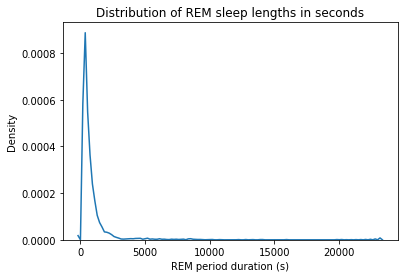

In [178]:
rem_periods, rem_lengths = rem_stats(rem_dict)
rem_length_density(rem_lengths)


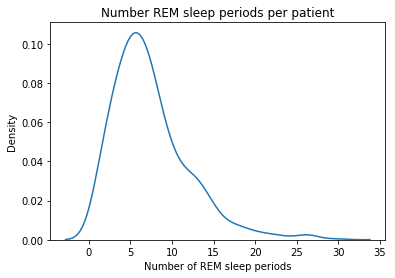

In [179]:
rem_period_density(rem_periods)


In [194]:
# Print out some summary statistics
print(f"Mean number of REM periods: {np.mean(rem_periods):1f}")
print(f"Median number of REM periods: {np.median(rem_periods)}")
print(f"Lowest number of REM periods: {np.min(rem_periods)}")
print(f"Highest number of REM periods: {np.max(rem_periods)}\n")

print(f"Mean duration of REM period (min): {np.mean(rem_lengths)/60:1f}")
print(f"Median duration of REM period (min): {np.median(rem_lengths)/60}")
print(f"Minimum duration of REM period (min): {np.min(rem_lengths)/60}")
print(f"Maximum duration of REM period (min): {np.max(rem_lengths)/60}")

Mean number of REM periods: 7.454047
Median number of REM periods: 7.0
Lowest number of REM periods: 1
Highest number of REM periods: 30

Mean duration of REM period (min): 9.582260
Median duration of REM period (min): 4.5
Minimum duration of REM period (min): 0.5
Maximum duration of REM period (min): 386.0


In [203]:
def calculate_gaps_in_rem(rem_dict):
    rem_gaps = []
    for patient in rem_dict:
        if len(rem_dict[patient].keys()) > 1:
            periods = sorted(list(rem_dict[patient].keys()))
            for i in range(2,len(periods)+1):
                rem_gaps.append(0.5*(rem_dict[patient][i]['start']-rem_dict[patient][i-1]['end']))
    return rem_gaps

def rem_gap_density(rem_gaps):
    sbn.distplot(rem_gaps, kde = True, hist = True)
    plt.title("Gaps between REM periods")
    plt.xlabel("Gaps (min)")
    plt.ylabel("Density")
                

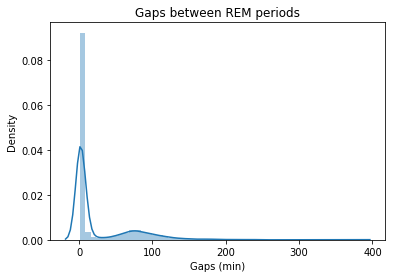

In [204]:
rem_gaps = calculate_gaps_in_rem(rem_dict)
rem_gap_density(rem_gaps)